# **Step 1: Load and Preprocess**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

spark = SparkSession.builder.appName("CUR_Task3").getOrCreate()

# Load data
path = "/content/drive/MyDrive/MMDS/Final/gold_prices.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(path)

In [ ]:
# Format types
df = df.withColumn("Date", col("Date").cast("date"))
df = df.withColumn("Buy Price", col("Buy Price").cast(DoubleType()))
df = df.withColumn("Sell Price", col("Sell Price").cast(DoubleType()))
df = df.orderBy("Date")

# **Step 2: Generate Features and Labels**

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
from pyspark.ml.feature import VectorAssembler

# Create lag features
windowSpec = Window.orderBy("Date")
for i in range(1, 11):
    df = df.withColumn(f"lag_{i}", lag("Buy Price", i).over(windowSpec))

df = df.na.drop()

# Assemble lag features
feature_cols = [f"lag_{i}" for i in range(10, 0, -1)]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Add label and keep date
data = df.select("Date", "features", col("Buy Price").alias("label"))

In [ ]:
# Count and compute index for split
total_count = data.count()
train_count = int(total_count * 0.7)

# Order and assign row numbers
from pyspark.sql.functions import monotonically_increasing_id
data = data.orderBy("Date").withColumn("row_id", monotonically_increasing_id())

# Time-based split
train_df = data.filter(col("row_id") < train_count).select("features", "label")
test_df = data.filter(col("row_id") >= train_count).select("features", "label")

# **Step 3: CURDecomposition Class**

In [ ]:
import numpy as np
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.mllib.linalg.distributed import RowMatrix

class CURDecomposition:
    def __init__(self, k):
        self.k = k  # number of columns to retain

    def _to_row_matrix(self, df):
        return RowMatrix(df.rdd.map(lambda row: Vectors.dense(row["features"])))

    def fit_transform(self, df):
        # Step 1: Convert features to RowMatrix
        row_matrix = self._to_row_matrix(df)

        # Step 2: Compute column norms to form sampling probabilities
        num_cols = len(df.first()["features"])
        col_norms = [0.0] * num_cols
        for row in df.select("features").collect():
            vec = row["features"]
            for i in range(num_cols):
                col_norms[i] += vec[i] ** 2

        total_norm = sum(col_norms)
        probs = [n / total_norm for n in col_norms]

        # Step 3: Sample columns based on probabilities
        sampled_indices = np.random.choice(range(num_cols), size=self.k, replace=False, p=probs)
        sampled_indices.sort()

        # Step 4: Extract C matrix (selected columns from features)
        def extract_selected_cols(row):
            full_vec = row["features"]
            return Vectors.dense([full_vec[i] for i in sampled_indices])

        selected_df = df.rdd.map(lambda row: (extract_selected_cols(row), row["label"])).toDF(["features", "label"])

        return selected_df, sampled_indices

# **Step 4: Apply CUR Decomposition to your train and test sets**

In [ ]:
# Initialize CUR class with k = 5
cur = CURDecomposition(k=5)

# Apply CUR decomposition to training set
train_reduced_df, selected_indices = cur.fit_transform(train_df)

# Apply same column indices to transform test set
def reduce_features(row):
    reduced_vector = [row["features"][i] for i in selected_indices]
    return (Vectors.dense(reduced_vector), row["label"])

test_reduced_df = test_df.rdd.map(reduce_features).toDF(["features", "label"])

In [ ]:
train_reduced_df.show(3)
test_reduced_df.show(3)

# **Step 5: Train and Evaluate a Linear Regression Model on Reduced Data**

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

def evaluate_model(predictions):
    evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
    evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)

    return rmse, mae, r2

# 1. Train on CUR Features
lr_cur = LinearRegression(featuresCol="features", labelCol="label")
model_cur = lr_cur.fit(train_reduced_df)

# Predictions
pred_train_cur = model_cur.transform(train_reduced_df)
pred_test_cur = model_cur.transform(test_reduced_df)

# CUR-based model
rmse_train_cur, mae_train_cur, r2_train_cur = evaluate_model(pred_train_cur)
rmse_test_cur, mae_test_cur, r2_test_cur = evaluate_model(pred_test_cur)

# 2. Train on Original Features
lr_orig = LinearRegression(featuresCol="features", labelCol="label")
model_orig = lr_orig.fit(train_df)

# Predictions
pred_train_orig = model_orig.transform(train_df)
pred_test_orig = model_orig.transform(test_df)

# Original feature model
rmse_train_orig, mae_train_orig, r2_train_orig = evaluate_model(pred_train_orig)
rmse_test_orig, mae_test_orig, r2_test_orig = evaluate_model(pred_test_orig)

In [ ]:
print("=== ORIGINAL FEATURES (10 dims) ===")
print(f"Train: RMSE={rmse_train_orig:.4f}, MAE={mae_train_orig:.4f}, R²={r2_train_orig:.4f}")
print(f"Test : RMSE={rmse_test_orig:.4f}, MAE={mae_test_orig:.4f}, R²={r2_test_orig:.4f}")

print("\n=== CUR-REDUCED FEATURES (5 dims) ===")
print(f"Train: RMSE={rmse_train_cur:.4f}, MAE={mae_train_cur:.4f}, R²={r2_train_cur:.4f}")
print(f"Test : RMSE={rmse_test_cur:.4f}, MAE={mae_test_cur:.4f}, R²={r2_test_cur:.4f}")

=== ORIGINAL FEATURES (10 dims) ===
Train: RMSE=0.2114, MAE=0.1069, R²=0.9983
Test : RMSE=0.4672, MAE=0.2222, R²=0.9977

=== CUR-REDUCED FEATURES (5 dims) ===
Train: RMSE=0.2117, MAE=0.1068, R²=0.9983
Test : RMSE=0.4682, MAE=0.2214, R²=0.9977


# **Step 6: Visualize and compare the metrics**

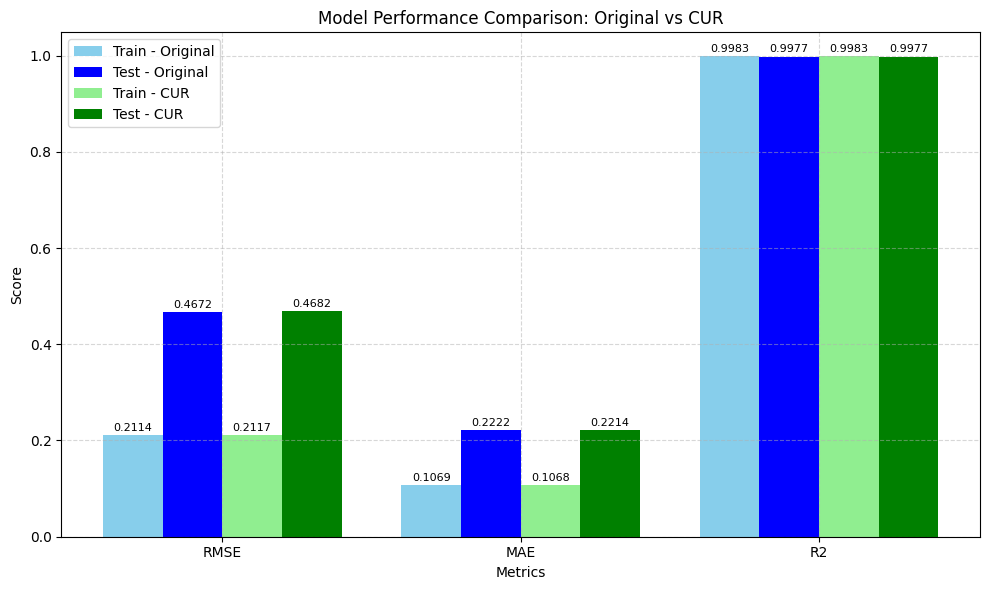

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'MAE', 'R2']
train_orig = [rmse_train_orig, mae_train_orig, r2_train_orig]
test_orig  = [rmse_test_orig,  mae_test_orig,  r2_test_orig]
train_cur  = [rmse_train_cur,  mae_train_cur,  r2_train_cur]
test_cur   = [rmse_test_cur,   mae_test_cur,   r2_test_cur]

# X axis positions
x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
bars1 = ax.bar(x - 1.5*width, train_orig, width, label='Train - Original', color='skyblue')
bars2 = ax.bar(x - 0.5*width, test_orig, width, label='Test - Original', color='blue')
bars3 = ax.bar(x + 0.5*width, train_cur,  width, label='Train - CUR', color='lightgreen')
bars4 = ax.bar(x + 1.5*width, test_cur,  width, label='Test - CUR', color='green')

# Axes
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Original vs CUR')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# .4f value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.show()